# Demonstrate XGBoost vs LightGBM capabilities:

#### This notebook will show how to use the XGBoost GPU accelerated sklearn classification interface along with LightGBM.

In this we'll explore:

- encoding catagoricals
- feature selection
- sampling to balance a dataset using over sampling
- displaying metrics, roc_auc and confusion matrix to evaluate models
- performance of XGB vs LightGBM
- comparison between feature importance of XGB and LGBM
- performance of Grid Search vs Randomized Search for best hyperparameters
- comparison of tuned model to default parameter models

In [1]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import xgboost as xgb
import lightgbm as lgb

import itertools

import pandas as pd
import numpy as np

np.random.seed(42)
 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib

import seaborn as sns

from IPython.core.pylabtools import figsize

# Import sklearn train-test split
from sklearn.model_selection import train_test_split
 
# Import some sklearn classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


from sklearn.preprocessing import RobustScaler

from scipy import stats

import json

## Exploratory Data Analysis

In [2]:
df = pd.read_csv('datasets/EmployeeAttrition.csv')
df.Attrition = df.Attrition.eq('No').mul(1)
target = 'Attrition'
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,0,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,1,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,0,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,1,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,1,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Convert categorical columns to one-hot-encoded form (dummies), keep top-n

In [3]:
features_to_keep = 7

category_df = df.select_dtypes('object')
dummy_df = pd.get_dummies(category_df)
dummy_df[target] = df[target]

# Find correlations with the target
most_correlated = dummy_df.corr().abs()[target].sort_values(ascending=False)

# Maintain the top-n most correlation features with Grade
most_correlated = most_correlated[:features_to_keep]
    
dummy_df = dummy_df.loc[:, most_correlated.index]
most_correlated

Attrition                           1.000000
OverTime_Yes                        0.246118
OverTime_No                         0.246118
MaritalStatus_Single                0.175419
JobRole_Sales Representative        0.157234
BusinessTravel_Travel_Frequently    0.115143
JobRole_Laboratory Technician       0.098290
Name: Attrition, dtype: float64

## Balance the data...

In [4]:
from sklearn.utils import resample

# Separate majority and minority classes
df_minority = dummy_df[dummy_df[target]==0]
df_majority = dummy_df[dummy_df[target]==1]

print("minority (0), len:", len(df_minority), "majority (0), len:", len(df_majority))
 
# Downsample majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
 
dummy_df = df_upsampled

minority (0), len: 237 majority (0), len: 1233


## Split the data for modeling

In [5]:
labels = dummy_df[target]
dummy_df = dummy_df.drop(columns = target)


# Split into training/testing sets with 20% split
X_train, X_test, y_train, y_test = train_test_split(dummy_df, labels, 
                                                    test_size = 0.20,
                                                    random_state = 42)



In [6]:
print(X_train.shape)
print(X_test.shape)


(1972, 6)
(494, 6)


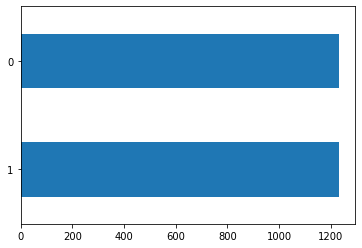

In [7]:
labels.value_counts().plot(kind="barh");


## calculate model metrics

In [8]:
def plot_confusion_matrix(y_train, y_predict_train, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_train, y_predict_train)
    classes = set(y_train)
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def show_metrics(y_test, y_train, y_predict_test, y_predict_train):
    # Create table of metric scores
    scores = {}
    scores['accuracy'] = (accuracy_score(y_test, y_predict_test), 
                          accuracy_score(y_train, y_predict_train))
    scores['roc_auc'] = (roc_auc_score(y_test, y_predict_test), 

    roc_auc_score(y_train, y_predict_train))

    scores_df = pd.DataFrame(scores).transpose()
    scores_df.columns = ['Test', 'Train']
    scores_df = scores_df[['Train', 'Test']]
    scores_df['Test-Train'] = scores_df.Test - scores_df.Train
    
    plot_confusion_matrix(y_train, y_predict_train)   
    
    print("\n-----------------------------------------------------")
    print(scores_df)
    print("\n-----------------------------------------------------")


## Build XGB (GPU accelerated model, default params)


-----------------------------------------------------
             Train      Test  Test-Train
accuracy  0.700304  0.696356   -0.003948
roc_auc   0.700163  0.696909   -0.003254

-----------------------------------------------------
CPU times: user 1.76 s, sys: 785 ms, total: 2.55 s
Wall time: 2.59 s


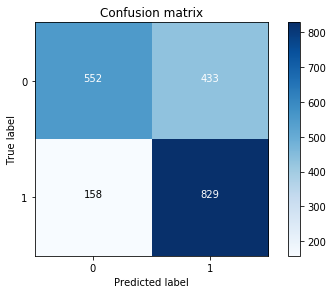

In [9]:
%%time

xgb_est = xgb.XGBClassifier(tree_method = 'gpu_hist', predictor= 'cpu_predictor', seed=42)


xgb_est.fit(X_train, y_train)

y_predict_test = xgb_est.predict(X_test)
y_predict_train = xgb_est.predict(X_train)
 
show_metrics(y_test, y_train, y_predict_test, y_predict_train)

## Build Light GBM model (default params)


-----------------------------------------------------
             Train      Test  Test-Train
accuracy  0.700304  0.696356   -0.003948
roc_auc   0.700163  0.696909   -0.003254

-----------------------------------------------------
None
CPU times: user 162 ms, sys: 0 ns, total: 162 ms
Wall time: 160 ms


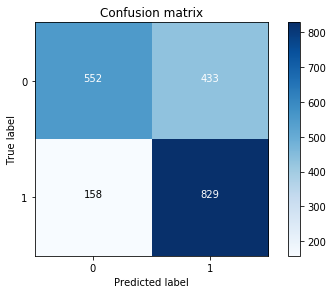

In [10]:
%%time

lgb_est = lgb.LGBMClassifier(seed=42)
lgb_est.fit(X_train, y_train)

y_predict_test = lgb_est.predict(X_test)
y_predict_train = lgb_est.predict(X_train)
 
print(show_metrics(y_test, y_train, y_predict_test, y_predict_train))

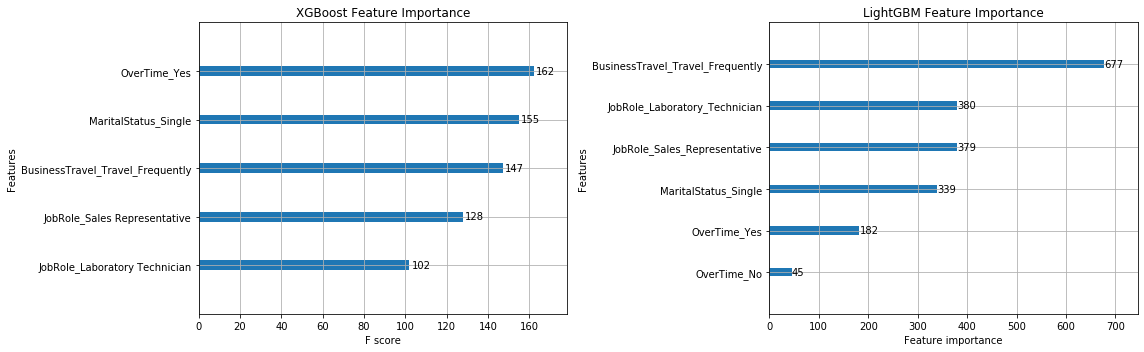

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

xgb.plot_importance(xgb_est, ax=ax[0], max_num_features=None, title="XGBoost Feature Importance")
lgb.plot_importance(lgb_est, ax=ax[1], max_num_features=None, title="LightGBM Feature Importance")
fig.tight_layout()
plt.show()

## Use Grid Search to tune hyperparameters

In [12]:
%%time

gridParams = {
    'learning_rate': [0.001, 0.0025, 0.005],
    'n_estimators': [50, 250],
    'num_leaves': [6, 12, 16],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 5, 10, 15]
}

clf = GridSearchCV(lgb.LGBMClassifier(seed=42), gridParams, cv=3, verbose=1, n_jobs=8)
clf.fit(X_train, y_train)

print(clf.best_score_, json.dumps(clf.best_params_,indent=2))

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 1032 tasks      | elapsed:    7.7s


0.6952332657200812 {
  "learning_rate": 0.005,
  "max_depth": 5,
  "min_child_weight": 1,
  "n_estimators": 250,
  "num_leaves": 12,
  "subsample": 0.6
}
CPU times: user 2.44 s, sys: 148 ms, total: 2.59 s
Wall time: 13.7 s


[Parallel(n_jobs=8)]: Done 1944 out of 1944 | elapsed:   13.6s finished


In [14]:
## Show metrics and CM for best tuned model


-----------------------------------------------------
             Train      Test  Test-Train
accuracy  0.700304  0.696356   -0.003948
roc_auc   0.700163  0.696909   -0.003254

-----------------------------------------------------
None


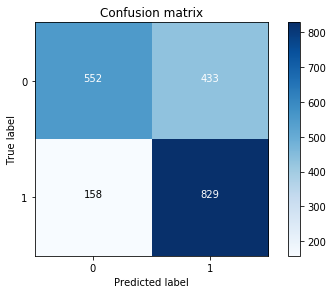

In [15]:
y_predict_test = clf.best_estimator_.predict(X_test)
y_predict_train = clf.best_estimator_.predict(X_train)
 
print(show_metrics(y_test, y_train, y_predict_test, y_predict_train))

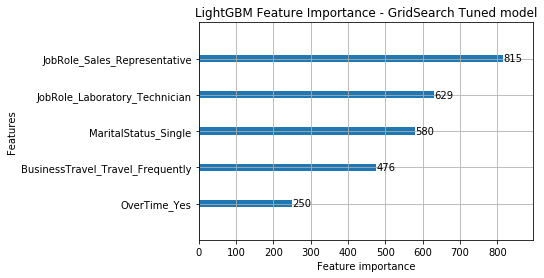

In [16]:
fig, ax = plt.subplots()
lgb.plot_importance(clf.best_estimator_, ax=ax, max_num_features=None, title="LightGBM Feature Importance - GridSearch Tuned model")
plt.show()

## Use Random Search to tune hyperparameters

In [17]:
%%time

gridParams = {
    'learning_rate': [0.001, 0.0025, 0.005],
    'n_estimators': stats.randint(50, 1500),
    'num_leaves': stats.randint(6, 20),
    'min_child_weight': stats.randint(1, 10),
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 5, 10, 15]
}

clf = RandomizedSearchCV(lgb.LGBMClassifier(seed=42), gridParams, cv=3, verbose=1, n_jobs=8)
clf.fit(X_train, y_train)

print(clf.best_score_, json.dumps(clf.best_params_,indent=2))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    1.3s finished


0.6937119675456389 {
  "learning_rate": 0.005,
  "max_depth": 15,
  "min_child_weight": 8,
  "n_estimators": 1094,
  "num_leaves": 12,
  "subsample": 0.8
}
CPU times: user 424 ms, sys: 1.97 ms, total: 426 ms
Wall time: 1.64 s


## Show metrics and CM for best tuned model


-----------------------------------------------------
             Train      Test  Test-Train
accuracy  0.700304  0.712551    0.012246
roc_auc   0.700189  0.712939    0.012750

-----------------------------------------------------
None


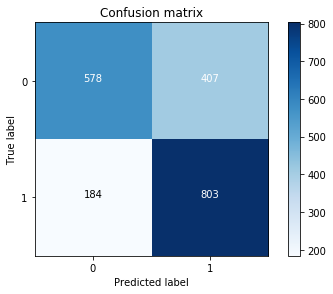

In [18]:
y_predict_test = clf.best_estimator_.predict(X_test)
y_predict_train = clf.best_estimator_.predict(X_train)
 
print(show_metrics(y_test, y_train, y_predict_test, y_predict_train))

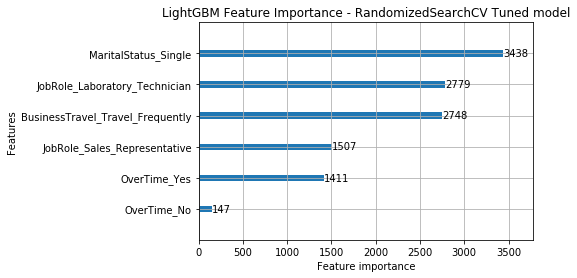

In [19]:
fig, ax = plt.subplots()
lgb.plot_importance(clf.best_estimator_, ax=ax, max_num_features=None, title="LightGBM Feature Importance - RandomizedSearchCV Tuned model")
plt.show()